<a href="https://www.kaggle.com/code/sachins8201/tabnet?scriptVersionId=274781597" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pytorch-tabnet imbalanced-learn scikit-learn dask_ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

In [2]:
import pandas as pd
import numpy as np
from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE
import dask.dataframe as dd
from sklearn.feature_selection import mutual_info_classif
from dask_ml.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import (confusion_matrix, classification_report,
                             hamming_loss, f1_score, roc_curve, roc_auc_score,accuracy_score)
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = dd.read_csv(
    "/kaggle/input/gotham/merged_dataset.csv",
    dtype={
        'tcp.checksum': 'object',
        'tcp.flags': 'object',
        'tcp.options': 'object'
    },
    assume_missing=True,  # allows mixed types
    blocksize="256MB"      # adjust based on RAM
)
df

,frame.time,frame.len,frame.protocols,eth.src,eth.dst,ip.dst,ip.src,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.tos,tcp.srcport,tcp.dstport,tcp.flags,tcp.window_size_value,tcp.window_size_scalefactor,tcp.checksum,tcp.options,tcp.pdu.size,udp.srcport,udp.dstport,label
npartitions=27,,,,,,,,,,,,,,,,,,,,,,,
,string,float64,string,string,string,string,string,string,float64,float64,string,float64,float64,float64,string,float64,float64,string,string,float64,float64,float64,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
df.columns

Index(['frame.time', 'frame.len', 'frame.protocols', 'eth.src', 'eth.dst',
       'ip.dst', 'ip.src', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.checksum',
       'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.flags',
       'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.checksum',
       'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label'],
      dtype='object')

In [5]:
df.dtypes

frame.time                     string[pyarrow]
frame.len                              float64
frame.protocols                string[pyarrow]
eth.src                        string[pyarrow]
eth.dst                        string[pyarrow]
ip.dst                         string[pyarrow]
ip.src                         string[pyarrow]
ip.flags                       string[pyarrow]
ip.ttl                                 float64
ip.proto                               float64
ip.checksum                    string[pyarrow]
ip.tos                                 float64
tcp.srcport                            float64
tcp.dstport                            float64
tcp.flags                      string[pyarrow]
tcp.window_size_value                  float64
tcp.window_size_scalefactor            float64
tcp.checksum                   string[pyarrow]
tcp.options                    string[pyarrow]
tcp.pdu.size                           float64
udp.srcport                            float64
udp.dstport  

In [6]:
attack_counts = df['label'].value_counts().compute()
print(attack_counts)

label
CoAP Amplification            274837
Merlin TCP Flooding           120000
Reporting                        450
Unknown                         7670
Telnet Brute Force            227649
Mirai GRE Flooding           5911401
UDP Scan                        4242
Mirai UDP Flooding           8897895
File Download                   7196
C&C Communication                528
TCP Scan                      737764
Merlin C&C Communication       29356
Ingress Tool Transfer          21587
Benign                      12256883
Merlin UDP Flooding            29996
Mirai C&C Communication         1074
Mirai TCP Flooding           6548173
Merlin ICMP Flooding           57580
Name: count, dtype: int64[pyarrow]


In [7]:
# Drop unnecessary columns
df = df.drop(columns=['ip.checksum', 'tcp.checksum'], errors='ignore')

# Reset index FIRST before any transformations
print("Resetting index...")
df = df.reset_index(drop=True)

# -------------------
# Time-based features
# -------------------
df['frame.time'] = dd.to_datetime(df['frame.time'], errors='coerce')
df['hour'] = df['frame.time'].dt.hour.fillna(-1).astype('int32')
df['minute'] = df['frame.time'].dt.minute.fillna(-1).astype('int32')
df['second'] = df['frame.time'].dt.second.fillna(-1).astype('int32')

# -------------------
# Protocol type indicators
# -------------------
df['is_tcp'] = df['tcp.srcport'].notnull().astype('int8')
df['is_udp'] = df['udp.srcport'].notnull().astype('int8')

# -------------------
# Handle nulls in numeric columns safely
# -------------------
null_fill_cols = ['ip.tos','tcp.srcport','tcp.dstport','tcp.options',
                  'tcp.pdu.size','udp.srcport','udp.dstport']
for col in null_fill_cols:
    if col in df.columns:
        df[col] = dd.to_numeric(df[col], errors='coerce').fillna(0).astype('float32')

# -------------------
# Packet size features
# -------------------
df['total_bytes'] = df['frame.len'].fillna(0)
if 'tcp.window_size_value' in df.columns:
    df['tcp.window_size_value'] = df['tcp.window_size_value'].fillna(0)
if 'tcp.window_size_scalefactor' in df.columns:
    df['tcp.window_size_scalefactor'] = df['tcp.window_size_scalefactor'].fillna(0)
    df['src_dst_bytes_diff'] = df['tcp.window_size_value'] - df['tcp.window_size_scalefactor']

# -------------------
# TCP flags handling
# -------------------
if 'tcp.flags' in df.columns:
    df['tcp.flags_num'] = dd.to_numeric(df['tcp.flags'], errors='coerce').fillna(0).astype('int32')
    df['syn_flag'] = ((df['tcp.flags_num'] & 0x02) > 0).astype('int8')
    df['ack_flag'] = ((df['tcp.flags_num'] & 0x10) > 0).astype('int8')
    df = df.drop(columns=['tcp.flags_num', 'tcp.flags'])

# -------------------
# Frequency encoding for IP/MAC addresses
# -------------------
ip_cols = ['ip.src', 'ip.dst', 'eth.src', 'eth.dst']
for col in ip_cols:
    if col in df.columns:
        freq_map = df[col].value_counts().compute()
        df[col + '_freq'] = df[col].map_partitions(
            lambda x: x.map(freq_map).fillna(0), 
            meta=('freq', 'f4')
        )

# -------------------
# Frequency encode other categorical columns
# -------------------
cat_cols = ['frame.protocols', 'ip.flags']
for col in cat_cols:
    if col in df.columns:
        freq_map = df[col].value_counts().compute()
        df[col + '_freq'] = df[col].map_partitions(
            lambda x: x.map(freq_map).fillna(0), 
            meta=(col + '_freq', 'f4')
        )

# -------------------
# Drop original categorical columns and time
# -------------------
drop_cols = ['frame.time', 'ip.src', 'ip.dst', 'eth.src', 'eth.dst', 
             'frame.protocols', 'ip.flags']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# -------------------
# Fill any remaining nulls in numeric columns
# -------------------
num_cols = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(0)

print("Feature engineering completed successfully!")
# DON'T compute here - just show column info
print(f"Number of columns: {len(df.columns)}")
print(f"Columns: {list(df.columns)}")

Resetting index...
Feature engineering completed successfully!
Number of columns: 28
Columns: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label', 'hour', 'minute', 'second', 'is_tcp', 'is_udp', 'total_bytes', 'src_dst_bytes_diff', 'syn_flag', 'ack_flag', 'ip.src_freq', 'ip.dst_freq', 'eth.src_freq', 'eth.dst_freq', 'frame.protocols_freq', 'ip.flags_freq']


In [8]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

print("\n=== Encoding Labels ===")

# Use dictionary mapping to avoid index issues
labels_pd = df['label'].compute()
le = LabelEncoder()
le.fit(labels_pd)

# Create mapping dictionary
label_mapping = {label: int(idx) for idx, label in enumerate(le.classes_)}
print(f"Label mapping: {label_mapping}")

# Apply mapping
df['label_encoded'] = df['label'].map_partitions(
    lambda x: x.map(label_mapping).fillna(-1).astype('int32'),
    meta=('label_encoded', 'int32')
)

# Save encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print(f"Label classes: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")

# Drop original label


print("Label encoding complete!")


=== Encoding Labels ===
Label mapping: {'Benign': 0, 'C&C Communication': 1, 'CoAP Amplification': 2, 'File Download': 3, 'Ingress Tool Transfer': 4, 'Merlin C&C Communication': 5, 'Merlin ICMP Flooding': 6, 'Merlin TCP Flooding': 7, 'Merlin UDP Flooding': 8, 'Mirai C&C Communication': 9, 'Mirai GRE Flooding': 10, 'Mirai TCP Flooding': 11, 'Mirai UDP Flooding': 12, 'Reporting': 13, 'TCP Scan': 14, 'Telnet Brute Force': 15, 'UDP Scan': 16, 'Unknown': 17}
Label classes: ['Benign' 'C&C Communication' 'CoAP Amplification' 'File Download'
 'Ingress Tool Transfer' 'Merlin C&C Communication' 'Merlin ICMP Flooding'
 'Merlin TCP Flooding' 'Merlin UDP Flooding' 'Mirai C&C Communication'
 'Mirai GRE Flooding' 'Mirai TCP Flooding' 'Mirai UDP Flooding'
 'Reporting' 'TCP Scan' 'Telnet Brute Force' 'UDP Scan' 'Unknown']
Number of classes: 18
Label encoding complete!


In [9]:
# NOW it's safe to compute
print("Computing null counts...")
null_counts = df.isnull().sum().compute()
print(f"\nNull counts:\n{null_counts[null_counts > 0]}")

print("\nFinal DataFrame Info:")
print(f"Shape: {df.compute().shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:\n{df.head()}")

Computing null counts...

Null counts:
Series([], dtype: int64)

Final DataFrame Info:
Shape: (35134281, 29)
Columns: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label', 'hour', 'minute', 'second', 'is_tcp', 'is_udp', 'total_bytes', 'src_dst_bytes_diff', 'syn_flag', 'ack_flag', 'ip.src_freq', 'ip.dst_freq', 'eth.src_freq', 'eth.dst_freq', 'frame.protocols_freq', 'ip.flags_freq', 'label_encoded']

First few rows:
   frame.len  ip.ttl  ip.proto  ip.tos  tcp.srcport  tcp.dstport  \
0       67.0    64.0      17.0     0.0          0.0          0.0   
1       83.0    61.0      17.0     0.0          0.0          0.0   
2       90.0    64.0      17.0     0.0          0.0          0.0   
3       90.0    61.0      17.0     0.0          0.0          0.0   
4       76.0    64.0      17.0     0.0          0.0          0.0   

   tcp.window_size_value 

In [10]:
df.dtypes

frame.len                              float64
ip.ttl                                 float64
ip.proto                               float64
ip.tos                                 float32
tcp.srcport                            float32
tcp.dstport                            float32
tcp.window_size_value                  float64
tcp.window_size_scalefactor            float64
tcp.options                            float32
tcp.pdu.size                           float32
udp.srcport                            float32
udp.dstport                            float32
label                          string[pyarrow]
hour                                     int32
minute                                   int32
second                                   int32
is_tcp                                    int8
is_udp                                    int8
total_bytes                            float64
src_dst_bytes_diff                     float64
syn_flag                                  int8
ack_flag     

In [11]:
y = df['label_encoded']
X = df.drop(columns=['label','label_encoded'])

In [12]:
X=X.astype("float64")

In [13]:
X.dtypes

frame.len                      float64
ip.ttl                         float64
ip.proto                       float64
ip.tos                         float64
tcp.srcport                    float64
tcp.dstport                    float64
tcp.window_size_value          float64
tcp.window_size_scalefactor    float64
tcp.options                    float64
tcp.pdu.size                   float64
udp.srcport                    float64
udp.dstport                    float64
hour                           float64
minute                         float64
second                         float64
is_tcp                         float64
is_udp                         float64
total_bytes                    float64
src_dst_bytes_diff             float64
syn_flag                       float64
ack_flag                       float64
ip.src_freq                    float64
ip.dst_freq                    float64
eth.src_freq                   float64
eth.dst_freq                   float64
frame.protocols_freq     

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

/usr/local/lib/python3.11/dist-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [16]:
tabnet_clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='sparsemax',
    scheduler_params={"step_size":10, "gamma":0.9},  # gradual LR decay
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [17]:
samples = []
N = 500  # or whatever your N value is

for label_name in attack_counts.index:
    # Filter only this label
    label_df = df[df['label'] == label_name]
    
    # Get actual count for this label
    actual_count = attack_counts[label_name]
    sample_count = min(N, actual_count)
    
    # Calculate fraction to sample
    frac = sample_count / actual_count
    
    # Sample using fraction (safer for Dask)
    sampled = label_df.sample(frac=frac, random_state=42)
    samples.append(sampled)
    
    print(f"Sampled {sample_count} from {label_name} ({actual_count} total)")

# Combine all small samples
balanced_df = dd.concat(samples)

# Trigger compute to bring small dataset to memory
balanced_df = balanced_df.compute()

# Separate features and labels
X_train_dask = balanced_df.drop(['label_encoded',"label"], axis=1)
y_train_dask = balanced_df['label_encoded']

for col in X_train_dask.columns:
    if 'pyarrow' in str(X_train_dask[col].dtype):
        X_train_dask[col] = X_train_dask[col].astype('int64')

X_np = X_train_dask.astype('float32')
y_np = y_train_dask.astype('int64')

X_np = X_train_dask.to_numpy()
y_np = y_train_dask.to_numpy()



print(f"\nFinal balanced dataset shape: {X_np.shape}")
print(f"Label distribution:\n{pd.Series(y_np).value_counts()}")

Sampled 500 from CoAP Amplification (274837 total)
Sampled 500 from Merlin TCP Flooding (120000 total)
Sampled 450 from Reporting (450 total)
Sampled 500 from Unknown (7670 total)
Sampled 500 from Telnet Brute Force (227649 total)
Sampled 500 from Mirai GRE Flooding (5911401 total)
Sampled 500 from UDP Scan (4242 total)
Sampled 500 from Mirai UDP Flooding (8897895 total)
Sampled 500 from File Download (7196 total)
Sampled 500 from C&C Communication (528 total)
Sampled 500 from TCP Scan (737764 total)
Sampled 500 from Merlin C&C Communication (29356 total)
Sampled 500 from Ingress Tool Transfer (21587 total)
Sampled 500 from Benign (12256883 total)
Sampled 500 from Merlin UDP Flooding (29996 total)
Sampled 500 from Mirai C&C Communication (1074 total)
Sampled 500 from Mirai TCP Flooding (6548173 total)
Sampled 500 from Merlin ICMP Flooding (57580 total)

Final balanced dataset shape: (8942, 27)
Label distribution:
11    502
10    501
6     500
2     500
15    500
17    500
3     500
12 

In [18]:
print(X_train_dask.dtypes)

frame.len                      float64
ip.ttl                         float64
ip.proto                       float64
ip.tos                         float32
tcp.srcport                    float32
tcp.dstport                    float32
tcp.window_size_value          float64
tcp.window_size_scalefactor    float64
tcp.options                    float32
tcp.pdu.size                   float32
udp.srcport                    float32
udp.dstport                    float32
hour                             int32
minute                           int32
second                           int32
is_tcp                            int8
is_udp                            int8
total_bytes                    float64
src_dst_bytes_diff             float64
syn_flag                          int8
ack_flag                          int8
ip.src_freq                      int64
ip.dst_freq                      int64
eth.src_freq                     int64
eth.dst_freq                     int64
frame.protocols_freq     

In [19]:
tabnet_clf.fit(
    X_train=X_np, y_train=y_np,
    max_epochs=10,
    batch_size=256,          # smaller batch size → more gradient updates
    virtual_batch_size=64
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.44707 |  0:00:02s
epoch 1  | loss: 3.84269 |  0:00:03s
epoch 2  | loss: 2.90463 |  0:00:05s
epoch 3  | loss: 2.46149 |  0:00:06s
epoch 4  | loss: 2.19852 |  0:00:07s
epoch 5  | loss: 1.91203 |  0:00:09s
epoch 6  | loss: 1.72299 |  0:00:10s
epoch 7  | loss: 1.50488 |  0:00:12s
epoch 8  | loss: 1.27869 |  0:00:13s
epoch 9  | loss: 1.11531 |  0:00:14s


In [20]:
for i in tqdm(range(X_train.npartitions), desc="Training on partitions"):
    X_batch = X_train.get_partition(i).compute()
    y_batch = y_train.get_partition(i).compute()

    
    # Safety check: skip empty partitions
    if len(X_batch) == 0:
        continue
    
    # Convert to numpy arrays for TabNet
    X_np = X_batch.to_numpy()
    y_np = y_batch.to_numpy()
    
    # Ensure y_np is 1D
    y_np = np.ravel(y_np)

    # Continue learning from pretrained weights
    tabnet_clf.fit(
        X_train=X_np, y_train=y_np,
        max_epochs=10,
        patience=5,
        batch_size=1024,
        virtual_batch_size=128,
        warm_start=True  # Always continue from existing weights
    )

Training on partitions:   0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.32883 |  0:01:23s
epoch 1  | loss: 0.08343 |  0:02:45s
epoch 2  | loss: 0.06617 |  0:04:08s
epoch 3  | loss: 0.05314 |  0:05:32s
epoch 4  | loss: 0.04338 |  0:06:55s
epoch 5  | loss: 0.04115 |  0:08:17s
epoch 6  | loss: 0.03974 |  0:09:41s
epoch 7  | loss: 0.03917 |  0:11:04s
epoch 8  | loss: 0.03668 |  0:12:28s
epoch 9  | loss: 0.035   |  0:13:51s


Training on partitions:   4%|▎         | 1/27 [17:54<7:45:27, 1074.14s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.3697  |  0:01:24s
epoch 1  | loss: 0.00054 |  0:02:48s
epoch 2  | loss: 0.0004  |  0:04:13s
epoch 3  | loss: 0.00032 |  0:05:37s
epoch 4  | loss: 0.0004  |  0:07:02s
epoch 5  | loss: 0.0003  |  0:08:26s
epoch 6  | loss: 0.0002  |  0:09:51s
epoch 7  | loss: 0.00019 |  0:11:15s
epoch 8  | loss: 0.00029 |  0:12:40s
epoch 9  | loss: 0.00034 |  0:14:04s


Training on partitions:   7%|▋         | 2/27 [36:07<7:32:20, 1085.62s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.1905  |  0:01:14s
epoch 1  | loss: 0.00037 |  0:02:29s
epoch 2  | loss: 0.00031 |  0:03:43s
epoch 3  | loss: 0.0003  |  0:04:57s
epoch 4  | loss: 0.00028 |  0:06:11s
epoch 5  | loss: 0.00022 |  0:07:27s
epoch 6  | loss: 0.00024 |  0:08:41s
epoch 7  | loss: 0.00013 |  0:09:55s
epoch 8  | loss: 0.0001  |  0:11:09s
epoch 9  | loss: 9e-05   |  0:12:23s


Training on partitions:  11%|█         | 3/27 [51:48<6:47:42, 1019.27s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.09731 |  0:01:17s
epoch 1  | loss: 0.00071 |  0:02:35s
epoch 2  | loss: 0.00041 |  0:03:54s
epoch 3  | loss: 0.00029 |  0:05:12s
epoch 4  | loss: 0.00029 |  0:06:30s
epoch 5  | loss: 0.00021 |  0:07:48s
epoch 6  | loss: 0.00023 |  0:09:07s
epoch 7  | loss: 0.00022 |  0:10:25s
epoch 8  | loss: 0.00029 |  0:11:42s
epoch 9  | loss: 0.0002  |  0:13:00s


Training on partitions:  15%|█▍        | 4/27 [1:08:23<6:27:02, 1009.68s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99423 |  0:01:19s
epoch 1  | loss: 0.02166 |  0:02:38s
epoch 2  | loss: 0.01867 |  0:04:00s
epoch 3  | loss: 0.01658 |  0:05:20s
epoch 4  | loss: 0.01575 |  0:06:40s
epoch 5  | loss: 0.01421 |  0:07:59s
epoch 6  | loss: 0.0134  |  0:09:20s
epoch 7  | loss: 0.0127  |  0:10:40s
epoch 8  | loss: 0.01294 |  0:12:00s
epoch 9  | loss: 0.01244 |  0:13:19s


Training on partitions:  19%|█▊        | 5/27 [1:25:24<6:11:42, 1013.75s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.30966 |  0:01:17s
epoch 1  | loss: 0.04323 |  0:02:34s
epoch 2  | loss: 0.0403  |  0:03:52s
epoch 3  | loss: 0.03947 |  0:05:09s
epoch 4  | loss: 0.03599 |  0:06:26s
epoch 5  | loss: 0.03553 |  0:07:44s
epoch 6  | loss: 0.03476 |  0:09:02s
epoch 7  | loss: 0.03429 |  0:10:19s
epoch 8  | loss: 0.03397 |  0:11:36s
epoch 9  | loss: 0.03368 |  0:12:54s


Training on partitions:  22%|██▏       | 6/27 [1:41:50<5:51:33, 1004.44s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.21773 |  0:01:24s
epoch 1  | loss: 0.00021 |  0:02:48s
epoch 2  | loss: 0.00015 |  0:04:13s
epoch 3  | loss: 0.00011 |  0:05:37s
epoch 4  | loss: 8e-05   |  0:07:01s
epoch 5  | loss: 6e-05   |  0:08:26s
epoch 6  | loss: 6e-05   |  0:09:51s
epoch 7  | loss: 5e-05   |  0:11:15s
epoch 8  | loss: 5e-05   |  0:12:39s
epoch 9  | loss: 4e-05   |  0:14:04s


Training on partitions:  26%|██▌       | 7/27 [2:00:02<5:44:22, 1033.12s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.23575 |  0:01:22s
epoch 1  | loss: 0.0003  |  0:02:46s
epoch 2  | loss: 0.00023 |  0:04:08s
epoch 3  | loss: 0.00019 |  0:05:31s
epoch 4  | loss: 0.00014 |  0:06:54s
epoch 5  | loss: 9e-05   |  0:08:17s
epoch 6  | loss: 0.00011 |  0:09:40s
epoch 7  | loss: 0.00012 |  0:11:02s
epoch 8  | loss: 7e-05   |  0:12:25s
epoch 9  | loss: 5e-05   |  0:13:48s


Training on partitions:  30%|██▉       | 8/27 [2:17:48<5:30:28, 1043.59s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.01177 |  0:01:12s
epoch 1  | loss: 0.00011 |  0:02:23s
epoch 2  | loss: 9e-05   |  0:03:35s
epoch 3  | loss: 8e-05   |  0:04:47s
epoch 4  | loss: 8e-05   |  0:05:58s
epoch 5  | loss: 0.0001  |  0:07:10s
epoch 6  | loss: 7e-05   |  0:08:21s
epoch 7  | loss: 7e-05   |  0:09:33s
epoch 8  | loss: 5e-05   |  0:10:46s
epoch 9  | loss: 0.0001  |  0:11:58s


Training on partitions:  33%|███▎      | 9/27 [2:32:54<5:00:09, 1000.51s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.14663 |  0:01:19s
epoch 1  | loss: 0.00034 |  0:02:38s
epoch 2  | loss: 0.00027 |  0:03:58s
epoch 3  | loss: 0.00026 |  0:05:18s
epoch 4  | loss: 0.0002  |  0:06:37s
epoch 5  | loss: 0.00031 |  0:07:56s
epoch 6  | loss: 0.00019 |  0:09:16s
epoch 7  | loss: 0.00018 |  0:10:35s
epoch 8  | loss: 0.00019 |  0:11:54s
epoch 9  | loss: 0.00017 |  0:13:13s


Training on partitions:  37%|███▋      | 10/27 [2:49:47<4:44:35, 1004.42s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.60317 |  0:01:18s
epoch 1  | loss: 0.04897 |  0:02:36s
epoch 2  | loss: 0.04096 |  0:03:55s
epoch 3  | loss: 0.03886 |  0:05:12s
epoch 4  | loss: 0.03754 |  0:06:30s
epoch 5  | loss: 0.03592 |  0:07:48s
epoch 6  | loss: 0.03481 |  0:09:07s
epoch 7  | loss: 0.03662 |  0:10:26s
epoch 8  | loss: 0.03545 |  0:11:45s
epoch 9  | loss: 0.03349 |  0:13:03s


Training on partitions:  41%|████      | 11/27 [3:06:25<4:27:18, 1002.40s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.29453 |  0:01:20s
epoch 1  | loss: 0.02154 |  0:02:42s
epoch 2  | loss: 0.02004 |  0:04:05s
epoch 3  | loss: 0.01915 |  0:05:26s
epoch 4  | loss: 0.02036 |  0:06:47s
epoch 5  | loss: 0.01995 |  0:08:08s
epoch 6  | loss: 0.01854 |  0:09:30s
epoch 7  | loss: 0.01765 |  0:10:51s
epoch 8  | loss: 0.01671 |  0:12:11s
epoch 9  | loss: 0.01679 |  0:13:32s


Training on partitions:  44%|████▍     | 12/27 [3:23:47<4:13:37, 1014.50s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.22761 |  0:01:21s
epoch 1  | loss: 0.00228 |  0:02:41s
epoch 2  | loss: 0.00176 |  0:04:03s
epoch 3  | loss: 0.00179 |  0:05:24s
epoch 4  | loss: 0.00135 |  0:06:44s
epoch 5  | loss: 0.00093 |  0:08:05s
epoch 6  | loss: 0.00071 |  0:09:26s
epoch 7  | loss: 0.00064 |  0:10:47s
epoch 8  | loss: 0.00046 |  0:12:08s
epoch 9  | loss: 0.00059 |  0:13:28s


Training on partitions:  48%|████▊     | 13/27 [3:41:04<3:58:18, 1021.34s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08337 |  0:01:31s
epoch 1  | loss: 0.0001  |  0:03:02s
epoch 2  | loss: 8e-05   |  0:04:34s
epoch 3  | loss: 5e-05   |  0:06:05s
epoch 4  | loss: 5e-05   |  0:07:36s
epoch 5  | loss: 5e-05   |  0:09:08s
epoch 6  | loss: 4e-05   |  0:10:40s
epoch 7  | loss: 3e-05   |  0:12:11s
epoch 8  | loss: 2e-05   |  0:13:43s
epoch 9  | loss: 2e-05   |  0:15:14s


Training on partitions:  52%|█████▏    | 14/27 [4:01:05<3:53:02, 1075.55s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08737 |  0:01:30s
epoch 1  | loss: 0.0153  |  0:03:00s
epoch 2  | loss: 0.0131  |  0:04:30s
epoch 3  | loss: 0.01202 |  0:06:00s
epoch 4  | loss: 0.01405 |  0:07:30s
epoch 5  | loss: 0.015   |  0:08:59s
epoch 6  | loss: 0.01425 |  0:10:29s
epoch 7  | loss: 0.01193 |  0:12:00s
epoch 8  | loss: 0.01176 |  0:13:29s
epoch 9  | loss: 0.01137 |  0:14:59s


Training on partitions:  56%|█████▌    | 15/27 [4:20:45<3:41:24, 1107.03s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.62655 |  0:01:24s
epoch 1  | loss: 0.00073 |  0:02:50s
epoch 2  | loss: 0.0004  |  0:04:15s
epoch 3  | loss: 0.00032 |  0:05:40s
epoch 4  | loss: 0.0004  |  0:07:05s
epoch 5  | loss: 0.00028 |  0:08:31s
epoch 6  | loss: 0.00013 |  0:09:56s
epoch 7  | loss: 0.00021 |  0:11:21s
epoch 8  | loss: 4e-05   |  0:12:46s
epoch 9  | loss: 3e-05   |  0:14:11s


Training on partitions:  59%|█████▉    | 16/27 [4:39:07<3:22:39, 1105.45s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.53077 |  0:01:24s
epoch 1  | loss: 0.00047 |  0:02:48s
epoch 2  | loss: 0.00031 |  0:04:11s
epoch 3  | loss: 0.00024 |  0:05:34s
epoch 4  | loss: 0.00021 |  0:06:58s
epoch 5  | loss: 0.0002  |  0:08:22s
epoch 6  | loss: 0.00019 |  0:09:45s
epoch 7  | loss: 0.00021 |  0:11:09s
epoch 8  | loss: 0.00016 |  0:12:35s
epoch 9  | loss: 0.00022 |  0:14:00s


Training on partitions:  63%|██████▎   | 17/27 [4:57:12<3:03:12, 1099.28s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.09792 |  0:01:13s
epoch 1  | loss: 0.0003  |  0:02:26s
epoch 2  | loss: 0.00029 |  0:03:40s
epoch 3  | loss: 0.00021 |  0:04:54s
epoch 4  | loss: 0.00017 |  0:06:08s
epoch 5  | loss: 0.00017 |  0:07:21s
epoch 6  | loss: 0.00016 |  0:08:35s
epoch 7  | loss: 0.00016 |  0:09:48s
epoch 8  | loss: 0.0001  |  0:11:02s
epoch 9  | loss: 0.00016 |  0:12:16s


Training on partitions:  67%|██████▋   | 18/27 [5:12:43<2:37:18, 1048.69s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.11037 |  0:01:18s
epoch 1  | loss: 0.00021 |  0:02:35s
epoch 2  | loss: 0.00018 |  0:03:53s
epoch 3  | loss: 0.00016 |  0:05:11s
epoch 4  | loss: 0.00016 |  0:06:29s
epoch 5  | loss: 7e-05   |  0:07:47s
epoch 6  | loss: 5e-05   |  0:09:04s
epoch 7  | loss: 4e-05   |  0:10:22s
epoch 8  | loss: 0.00014 |  0:11:40s
epoch 9  | loss: 5e-05   |  0:12:58s


Training on partitions:  70%|███████   | 19/27 [5:29:13<2:17:29, 1031.21s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.09919 |  0:01:21s
epoch 1  | loss: 0.00019 |  0:02:42s
epoch 2  | loss: 0.00012 |  0:04:04s
epoch 3  | loss: 0.0001  |  0:05:25s
epoch 4  | loss: 0.00023 |  0:06:46s
epoch 5  | loss: 6e-05   |  0:08:09s
epoch 6  | loss: 7e-05   |  0:09:31s
epoch 7  | loss: 8e-05   |  0:10:53s
epoch 8  | loss: 0.00011 |  0:12:14s
epoch 9  | loss: 0.00011 |  0:13:36s


Training on partitions:  74%|███████▍  | 20/27 [5:46:41<2:00:54, 1036.33s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.08077 |  0:01:31s
epoch 1  | loss: 0.00301 |  0:03:03s
epoch 2  | loss: 0.00147 |  0:04:34s
epoch 3  | loss: 0.00081 |  0:06:05s
epoch 4  | loss: 0.00091 |  0:07:37s
epoch 5  | loss: 0.00068 |  0:09:07s
epoch 6  | loss: 0.0007  |  0:10:38s
epoch 7  | loss: 0.0006  |  0:12:09s
epoch 8  | loss: 0.00046 |  0:13:40s
epoch 9  | loss: 0.00053 |  0:15:11s


Training on partitions:  78%|███████▊  | 21/27 [6:06:37<1:48:24, 1084.10s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 4e-05   |  0:01:31s
epoch 1  | loss: 2e-05   |  0:03:02s
epoch 2  | loss: 1e-05   |  0:04:34s
epoch 3  | loss: 1e-05   |  0:06:05s
epoch 4  | loss: 1e-05   |  0:07:36s
epoch 5  | loss: 0.0     |  0:09:07s
epoch 6  | loss: 0.0     |  0:10:38s
epoch 7  | loss: 1e-05   |  0:12:09s
epoch 8  | loss: 1e-05   |  0:13:40s
epoch 9  | loss: 1e-05   |  0:15:12s


Training on partitions:  81%|████████▏ | 22/27 [6:26:34<1:33:10, 1118.09s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.05749 |  0:01:30s
epoch 1  | loss: 0.02207 |  0:02:59s
epoch 2  | loss: 0.02022 |  0:04:28s
epoch 3  | loss: 0.01947 |  0:05:58s
epoch 4  | loss: 0.01909 |  0:07:29s
epoch 5  | loss: 0.01859 |  0:08:59s
epoch 6  | loss: 0.018   |  0:10:29s
epoch 7  | loss: 0.01785 |  0:11:59s
epoch 8  | loss: 0.01772 |  0:13:28s
epoch 9  | loss: 0.01676 |  0:14:57s


Training on partitions:  85%|████████▌ | 23/27 [6:46:08<1:15:39, 1134.88s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.11944 |  0:01:29s
epoch 1  | loss: 0.00021 |  0:02:58s
epoch 2  | loss: 0.0001  |  0:04:28s
epoch 3  | loss: 5e-05   |  0:05:57s
epoch 4  | loss: 5e-05   |  0:07:26s
epoch 5  | loss: 7e-05   |  0:08:56s
epoch 6  | loss: 4e-05   |  0:10:25s
epoch 7  | loss: 3e-05   |  0:11:54s
epoch 8  | loss: 4e-05   |  0:13:23s
epoch 9  | loss: 2e-05   |  0:14:52s


Training on partitions:  89%|████████▉ | 24/27 [7:05:36<57:14, 1144.71s/it]  /usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.37196 |  0:01:20s
epoch 1  | loss: 0.00066 |  0:02:41s
epoch 2  | loss: 0.00083 |  0:04:01s
epoch 3  | loss: 0.00069 |  0:05:21s
epoch 4  | loss: 0.0004  |  0:06:42s
epoch 5  | loss: 0.00023 |  0:08:01s
epoch 6  | loss: 0.00024 |  0:09:21s
epoch 7  | loss: 0.00028 |  0:10:40s
epoch 8  | loss: 0.00021 |  0:12:01s
epoch 9  | loss: 0.00019 |  0:13:21s


Training on partitions:  93%|█████████▎| 25/27 [7:22:41<36:57, 1108.82s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.03475 |  0:01:31s
epoch 1  | loss: 0.00117 |  0:03:02s
epoch 2  | loss: 0.00073 |  0:04:33s
epoch 3  | loss: 0.00083 |  0:06:04s
epoch 4  | loss: 0.00065 |  0:07:35s
epoch 5  | loss: 0.00034 |  0:09:06s
epoch 6  | loss: 0.00067 |  0:10:37s
epoch 7  | loss: 0.00039 |  0:12:09s
epoch 8  | loss: 0.00033 |  0:13:40s
epoch 9  | loss: 0.00025 |  0:15:11s


Training on partitions:  96%|█████████▋| 26/27 [7:42:38<18:55, 1135.33s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0002  |  0:01:27s
epoch 1  | loss: 7e-05   |  0:02:56s
epoch 2  | loss: 6e-05   |  0:04:24s
epoch 3  | loss: 5e-05   |  0:05:51s
epoch 4  | loss: 4e-05   |  0:07:19s
epoch 5  | loss: 4e-05   |  0:08:48s
epoch 6  | loss: 4e-05   |  0:10:15s
epoch 7  | loss: 3e-05   |  0:11:42s
epoch 8  | loss: 3e-05   |  0:13:10s
epoch 9  | loss: 2e-05   |  0:14:38s


Training on partitions: 100%|██████████| 27/27 [8:01:44<00:00, 1070.55s/it]


In [21]:
X_test_np = X_test.compute().to_numpy()
y_test_np = np.ravel(y_test.compute().to_numpy())

In [22]:
y_pred = tabnet_clf.predict(X_test_np)

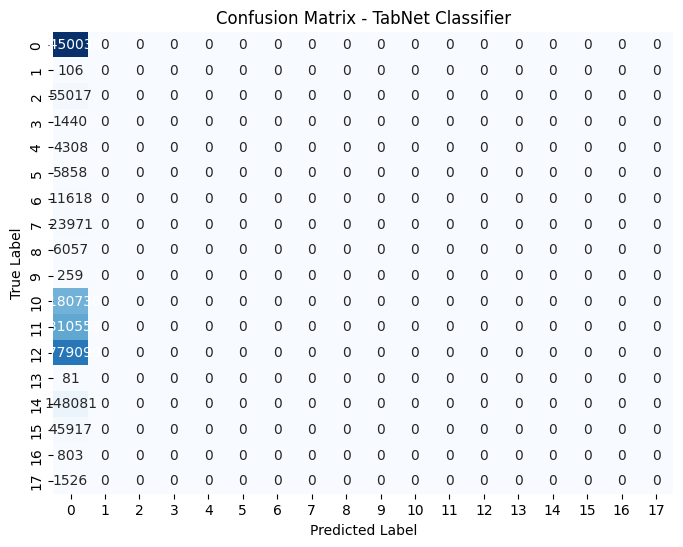

In [23]:
cm = confusion_matrix(y_test_np, y_pred)



# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - TabNet Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
# Step 3: Print Metrics
print("\n🔹 Classification Report:")
print(classification_report(y_test_np, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")


🔹 Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.35      1.00      0.52   2450038
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00     55017
           3       0.00      0.00      0.00      1440
           4       0.00      0.00      0.00      4308
           5       0.00      0.00      0.00      5858
           6       0.00      0.00      0.00     11618
           7       0.00      0.00      0.00     23971
           8       0.00      0.00      0.00      6057
           9       0.00      0.00      0.00       259
          10       0.00      0.00      0.00   1180730
          11       0.00      0.00      0.00   1310558
          12       0.00      0.00      0.00   1779099
          13       0.00      0.00      0.00        81
          14       0.00      0.00      0.00    148081
          15       0.00      0.00      0.00     45917
          16       0.00      0.00      0.00       803
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# Calculate key metrics
acc = accuracy_score(y_test_np, y_pred)
prec_macro = precision_score(y_test_np, y_pred, average='macro')
rec_macro  = recall_score(y_test_np, y_pred, average='macro')
f1_macro = f1_score(y_test_np, y_pred, average='macro')
f1_weighted = f1_score(y_test_np, y_pred, average='weighted')
hloss = hamming_loss(y_test_np, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 Macro Precision: {prec_macro:.4f}")
print(f"🎯 Macro Recall: {rec_macro:.4f}")
print(f"🎯 Macro F1-Score: {f1_macro:.4f}")
print(f"🎯 Weighted F1-Score: {f1_weighted:.4f}")
print(f"⚡ Hamming Loss: {hloss:.6f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Accuracy: 0.3487
🎯 Macro Precision: 0.0194
🎯 Macro Recall: 0.0556
🎯 Macro F1-Score: 0.0287
🎯 Weighted F1-Score: 0.1803
⚡ Hamming Loss: 0.651263


🧭 ROC-AUC (macro-average): 0.5226


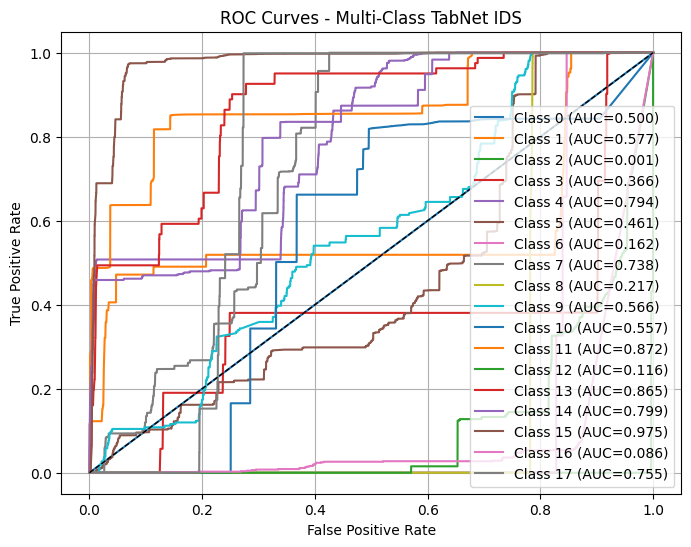

In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for multi-class ROC
classes = np.unique(y_test_np)
y_test_bin = label_binarize(y_test_np, classes=classes)
y_pred_prob = tabnet_clf.predict_proba(X_test_np)

# Compute ROC AUC per class
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"🧭 ROC-AUC (macro-average): {roc_auc:.4f}")

# Plot ROC Curves for each class
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC={auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves - Multi-Class TabNet IDS')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


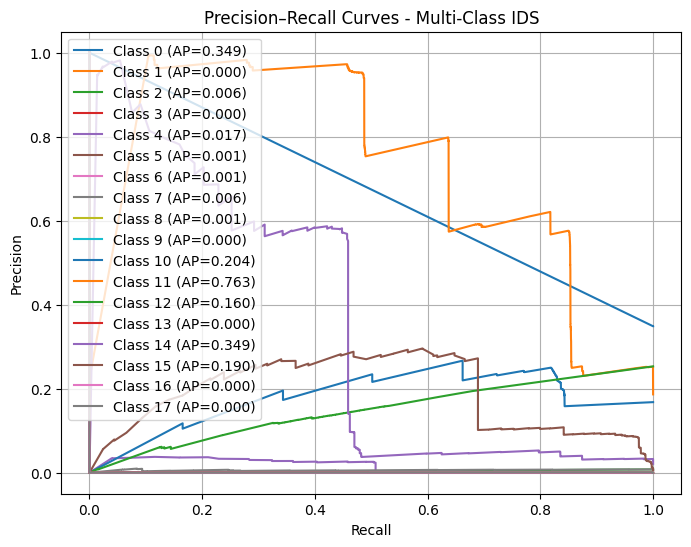

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {cls} (AP={avg_prec:.3f})')

plt.title('Precision–Recall Curves - Multi-Class IDS')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test_np, y_pred)
print(f"📏 Matthews Correlation Coefficient (MCC): {mcc:.4f}")


📏 Matthews Correlation Coefficient (MCC): 0.0000


In [29]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test_np, y_pred)
print(f"🧩 Cohen’s Kappa Score: {kappa:.4f}")


🧩 Cohen’s Kappa Score: 0.0000


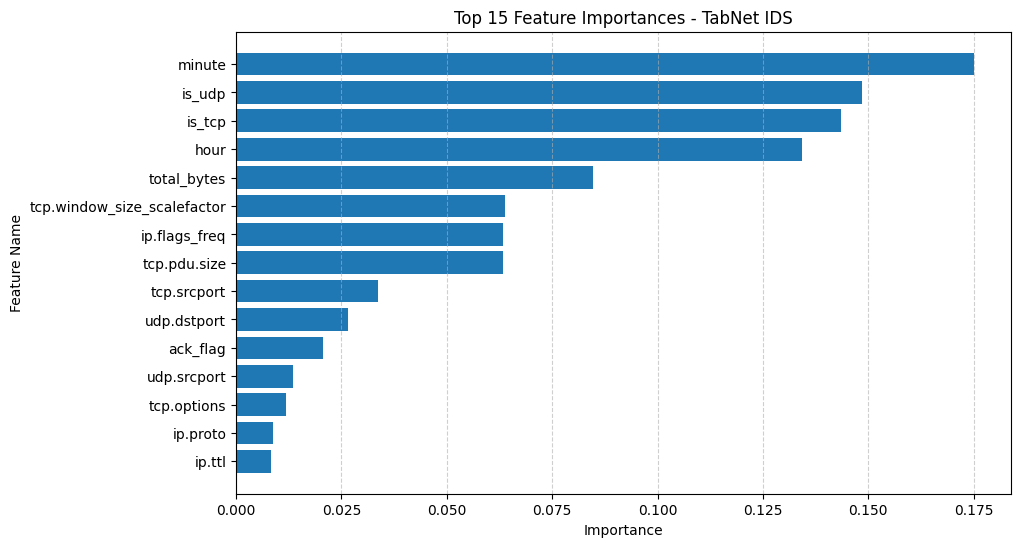

In [30]:
# Built-in interpretability (TabNet Attention Masks)
feature_importances = tabnet_clf.feature_importances_

# Sort and display
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_idx[:15]]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feature_importances[sorted_idx[:15]][::-1])
plt.title("Top 15 Feature Importances - TabNet IDS")
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [31]:
import pandas as pd

# Create a DataFrame to analyze wrong predictions
error_df = pd.DataFrame({
    'True_Label': y_test_np,
    'Predicted_Label': y_pred
})

misclassified = error_df[error_df['True_Label'] != error_df['Predicted_Label']]
print(f"⚠️ Total Misclassifications: {len(misclassified)}")
print("\nSample Misclassifications:")
print(misclassified.head(10))


⚠️ Total Misclassifications: 4575429

Sample Misclassifications:
     True_Label  Predicted_Label
551          15                0
552          15                0
553          15                0
554          15                0
555          15                0
556          15                0
557          15                0
558          15                0
559          15                0
560          15                0


In [32]:
results_summary = {
    'Accuracy': acc,
    'Macro_Precision': prec_macro,
    'Macro_Recall': rec_macro,
    'Macro_F1': f1_macro,
    'Weighted_F1': f1_weighted,
    'ROC_AUC': roc_auc,
    'MCC': mcc,
    'Cohen_Kappa': kappa,
    'Hamming_Loss': hloss
}

print("\n📘 Evaluation Summary (TabNet IDS):")
for metric, value in results_summary.items():
    print(f"{metric:<20}: {value:.4f}")



📘 Evaluation Summary (TabNet IDS):
Accuracy            : 0.3487
Macro_Precision     : 0.0194
Macro_Recall        : 0.0556
Macro_F1            : 0.0287
Weighted_F1         : 0.1803
ROC_AUC             : 0.5226
MCC                 : 0.0000
Cohen_Kappa         : 0.0000
Hamming_Loss        : 0.6513
